In [1]:
'''load qt5'''
%matplotlib qt5

In [1]:
'''import functions'''
import sip
for t in ["QDate", "QVariant", "QDateTime", "QTextStream", "QString", "QTime", "QUrl"]:
    sip.setapi(t, 2)
import hyperspy.api as hs
import hyperspy
import numpy as np
import matplotlib.pyplot as plt
import pandas.util.testing as tm
import pyUSID as usid
import math
import cv2
from PIL import Image
from sklearn.metrics import jaccard_score
from sklearn.decomposition import NMF
# hs.preferences.gui(toolkit="ipywidgets")
from skimage.metrics import structural_similarity as ssim
import time

/Users/beaver/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  if __name__ == '__main__':


In [50]:
def _soft_thresh(X, lambda1):
    """Soft-thresholding of array X."""
    res = np.abs(X) - lambda1
    np.maximum(res, 0.0, out=res)
    res *= np.sign(X)
    return res

In [52]:
def decompose(X, rank=1, lambda1=1, card=None, iterated_power=1, max_iter=100, tol=0.001):
    """
    Parameters
    ----------
    X : array-like, shape (n_features, n_samples), which will be decomposed into a sparse matrix S 
        and a low-rank matrix L.
    
    rank : int >= 1, optional
        The rank of low-rank matrix. The default is 1.
    
    card : int >= 0, optional
        The cardinality of the sparse matrix. The default is None (number of array elements in X).
    
    iterated_power : int >= 1, optional
        Number of iterations for the power method, increasing it lead to better accuracy and more time cost. The default is 1.
    
    max_iter : int >= 0, optional
        Maximum number of iterations to be run. The default is 100.
    
    tol : float >= 0, optional
        Tolerance for stopping criteria. The default is 0.001.
    Returns
    -------
    L : array-like, low-rank matrix.
    
    S : array-like, sparse matrix.
    LS : array-like, reconstruction matrix.
    
    RMSE : root-mean-square error.
    
    """
    iter = 1
    RMSE = []
    card = prod(X.shape) if card is None else card
    
    X = X.T if(X.shape[0] < X.shape[1]) else X
    m, n = X.shape
    
    # Initialization of L and S
    L = X
    S = zeros(X.shape)
    LS = zeros(X.shape)
    
    while True:
        # Update of L
        Y2 = randn(n, rank)
        for i in range(iterated_power):
            Y1 = L.dot(Y2)
            Y2 = L.T.dot(Y1)
        Q, R = qr(Y2, mode='economic')
        L_new = (L.dot(Q)).dot(Q.T)
        
        # Update of S
        T = L - L_new + S
        L = L_new
        S = _soft_thresh(T, lambda1)
        T_vec = T.reshape(-1)
        S_vec = S.reshape(-1)
        idx = abs(T_vec).argsort()[::-1]
        S_vec[idx[:card]] = T_vec[idx[:card]]
        S = S_vec.reshape(S.shape)
        
        # Reconstruction
        LS = L + S
        
        # Stopping criteria
        error = sqrt(mean_squared_error(X, LS))
        RMSE.append(error)
        
        print("iter: ", iter, "error: ", error)
        if (error <= tol) or (iter >= max_iter):
            break
        else:
            iter = iter + 1

    return L, S, LS, RMSE

In [2]:
def norm(x):
    xmax, xmin = x.max(), x.min()
    x = (x - xmin)/(xmax - xmin)
#     print(xmax - xmin)
    return x

In [3]:
def label(x):
    n, m = x.shape
    x_label = np.zeros([n, m])
    for i in range(n):
        for j in range(m):
            x_label[i,j] = int(round(x[i,j]*10))
    return x_label.flatten()

In [4]:
def label_ib(x):
    n, m = x.shape
    x_label = np.zeros([n, m])
    for i in range(n):
        for j in range(m):
            if x[i,j] < 0.2:
                x_label[i,j] = 0
            elif x[i,j] < 0.4:
                x_label[i,j] = 1
            elif x[i,j] < 0.6:
                x_label[i,j] = 2
            elif x[i,j] < 0.8:
                x_label[i,j] = 3
            else:
                x_label[i,j] = 4
    return x_label.flatten()

In [15]:
# s.plot()
print(s)

<EELSSpectrum, title: EELS Spectrum Image, dimensions: (40, 40|2048)>


In [5]:
s = hs.load('10c_si2.dm3')

In [ ]:
###### IF .DM3 #######
ground_truth = hs.load('10c_si2_HAADF.dm3')
ground_truth.plot()

ground_truth = norm(np.array(ground_truth))
print(ground_truth.shape)
ground_label = label_ib(ground_truth)

In [ ]:
###### IF .TIF #######
ground_truth = Image.open('10c_si2_HAADF.tif').convert('L')
ground_truth = ground_truth.resize((70,70))
ground_truth = norm(np.array(ground_truth))
print(ground_truth.shape)
ground_label = label_ib(ground_truth)

In [ ]:
Mn = Image.open('Mn.png').convert('L')
# Mn.show()
Mn_norm = norm(np.array(Mn))
Ce4 = Image.open('Ce4.png').convert('L')
# Ce4.show()
Ce4_norm = norm(np.array(Ce4))
Ce3 = Image.open('Ce3.png').convert('L')
# Ce3.show()
Ce3_norm = norm(np.array(Ce3))
# print(Mn.shape, Ce4.shape, Ce3.shape)

In [ ]:
exp_results_O = hs.load('./Mn_09_21/10c_si2_O.dm3')
exp_results_Mn = hs.load('./Mn_09_21/10c_si2_Mn.dm3')
exp_results_Ce3 = hs.load('./Mn_09_21/10c_si2_Ce3.dm3')
exp_results_Ce4 = hs.load('./Mn_09_21/10c_si2_Ce4.dm3')
exp_results = exp_results_Mn+exp_results_O+exp_results_Ce3+exp_results_Ce4
exp_results.plot()

# exp_results = hs.load('si4_exp.dm3')
exp_results = np.array(exp_results)
exp_results = norm(exp_results)
print(exp_results.shape)
exp_label = label_ib(exp_results)

In [ ]:
sim = ssim(ground_truth, exp_results)
print(sim)

print('weighted:', jaccard_score(ground_label, exp_label, average='weighted'))
print('each class:', jaccard_score(ground_label, exp_label, average=None))
print('accuracy:', jaccard_score(ground_label, exp_label, average='micro'))

In [ ]:
s_test = s.deepcopy()
s_test.decomposition()
s_test.plot_explained_variance_ratio(n=6)
s_test.plot_decomposition_loadings(comp_ids=6, axes_decor="off")

In [18]:
X = np.array(s)
X -= X.min()
width, height, n = X.shape
X = X.reshape(-1,n)
print(X.shape)

(1600, 2048)


In [55]:
L, S, LS, RMSE = decompose(X, lambda1=3, rank=3, card=None, iterated_power=0, max_iter=2000, tol=0.001)
pca = PCA(n_components=3, svd_solver='full')
pca.fit(L)
print(pca.components_.shape)
# U, S, Vh = svd_solve(L, output_dimension=3)
# print(U.shape, S.shape. Vh.shape)
# L = (L.T).reshape(width, height, n)
# S = (S.T).reshape(width, height, n)
# LS = (LS.T).reshape(width, height, n)

# S = hs.signals.Signal1D(S)
# S.plot()

iter:  1 error:  1.2193759069875507e-13
(3, 1600)


In [9]:
s_norm = s.deepcopy()
# if s_norm.data.min() < 0:
#     s_norm -= s_norm.data.min()
# s_norm -= s_norm.data.min()
# print(s_norm.data.min(), s_norm.data.max())
# print(s.data.min(), s.data.max())
# print((np.array(s.data).shape))

# s0_norm = s0.deepcopy()
# s0_norm -= s0_norm.data.min()
# print(s0_norm.data.min(), s0_norm.data.max())
# print(s0.data.min(), s0.data.max())
# print((np.array(s0.data).shape))


<EELSSpectrum, title: EELS Spectrum Image, dimensions: (40, 40|2048)>


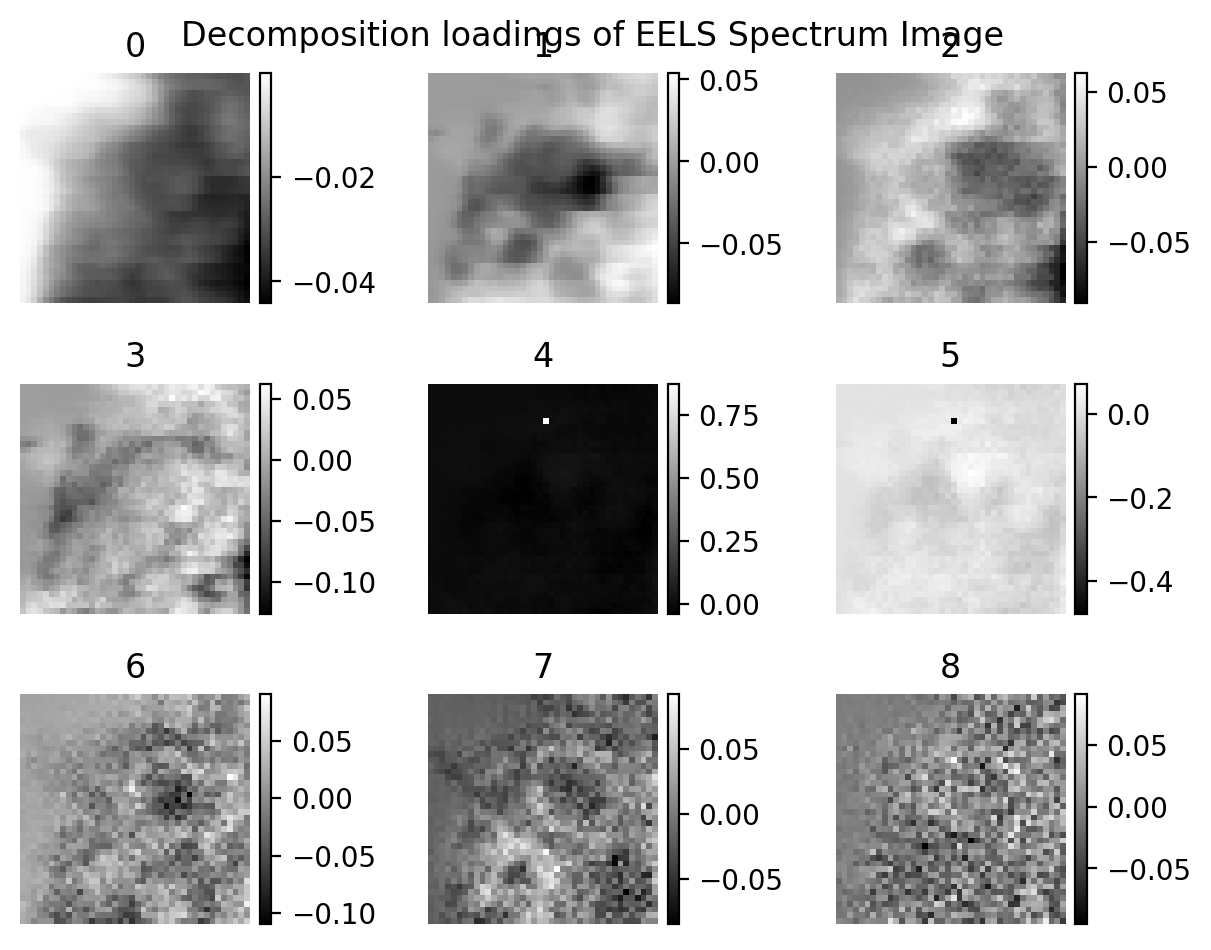

In [11]:
s_try = s_norm.deepcopy()
# s_try = s_try.isig[0.:150.]
print(s_try)
# s_try.plot()
# s_try.data = s_try.data[:,:,1000:]
# s_try.align_zero_loss_peak(signal_range=(400.,500.))
# EELS = hyperspy.signals.EELSSpectrum(s_try.data[:,:,1000:])
# print(EELS)
# EELS.plot()
s_try.decomposition()
s_try.plot_explained_variance_ratio(n=10)
s_try.plot_decomposition_loadings(comp_ids=9, axes_decor="off")

In [30]:
# s_godec = s_try.deepcopy()
# s_godec.decomposition(normalize_poissonian_noise = False, algorithm='RPCA_GoDec', lambda1=8, output_dimension=3, tol=1e-3, power=0, maxiter=3000)
# s_godec -= s_godec.data.min()
# s_godec.decomposition(normalize_poissonian_noise = False, algorithm='nmf', output_dimension=5)
s_godec.plot_decomposition_results()
# s_godec.plot_decomposition_loadings()

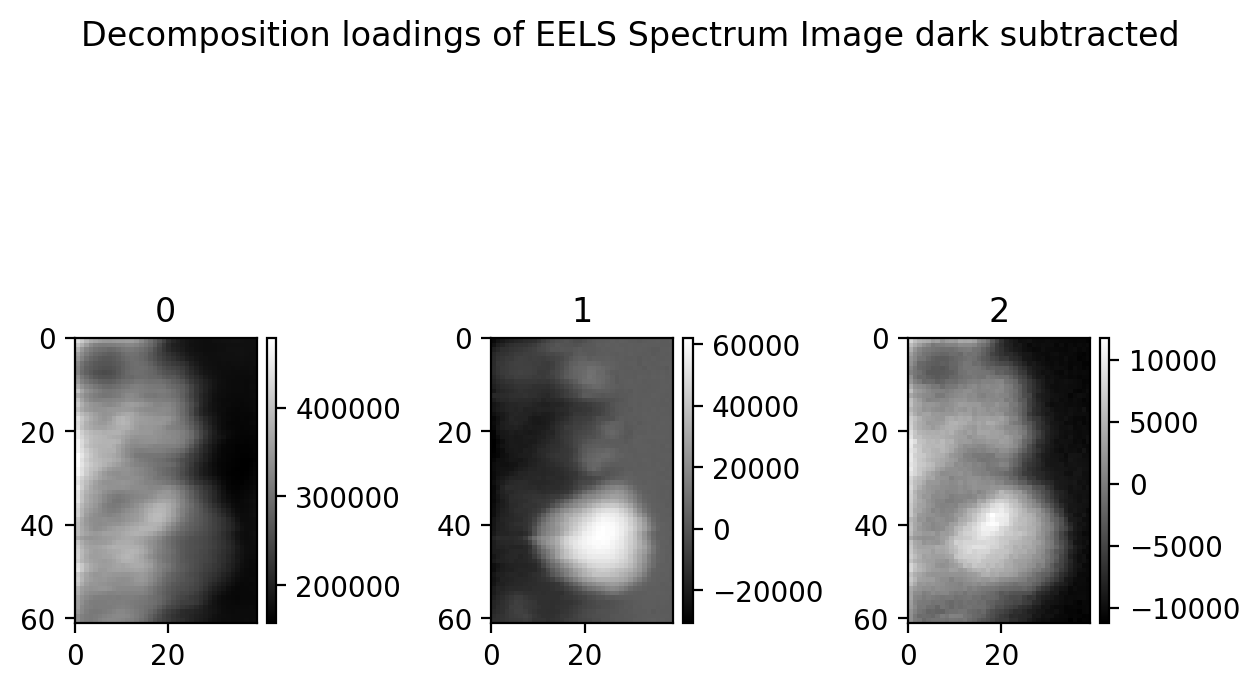

In [60]:
# s_svd = s_try.deepcopy()
# s_svd.decomposition(normalize_poissonian_noise = False, algorithm='RPCA_GoDec', lambda1=1, output_dimension=3, tol=1e-2, power=0, maxiter=2000)
# s_svd.plot_decomposition_results()
s_svd.plot_decomposition_loadings()

In [29]:
s_Ru = s_godec.get_decomposition_model(components=[1])
s2 = s_try - s_Ru #- s_godec.get_decomposition_model(components=[0])
# s2 = s2.isig[300.:600.]
s2.plot()
# s2 -= s2.data.min()
# s2.decomposition(normalize_poissonian_noise = False, algorithm='nmf', output_dimension=2)
# s2.decomposition(normalize_poissonian_noise = False, algorithm='RPCA_GoDec', lambda1=5, output_dimension=3, tol=1e-8, power=0, maxiter=2000)
# s2.plot_decomposition_results()

In [44]:
new = s_godec.get_decomposition_model(components=[1])
# new.data += 0.5*s_godec.get_decomposition_model(components=[2]).data
new.plot()

In [144]:
# s_mix = s_godec.get_decomposition_model(components=[0])
s0.plot()

In [45]:
new2 = s_godec.get_decomposition_model(components=[0])
new2.data -= 2*s_godec.get_decomposition_model(components=[2]).data
new2.plot()

In [53]:
s_svd = s_try.deepcopy()
s_svd.decomposition(normalize_poissonian_noise = False, algorithm='RPCA_GoDec', lambda1=0.3, output_dimension=4, tol=1e-2, power=0, maxiter=3000)
s_svd.plot_decomposition_results()
# s_svd.plot_decomposition_loadings()

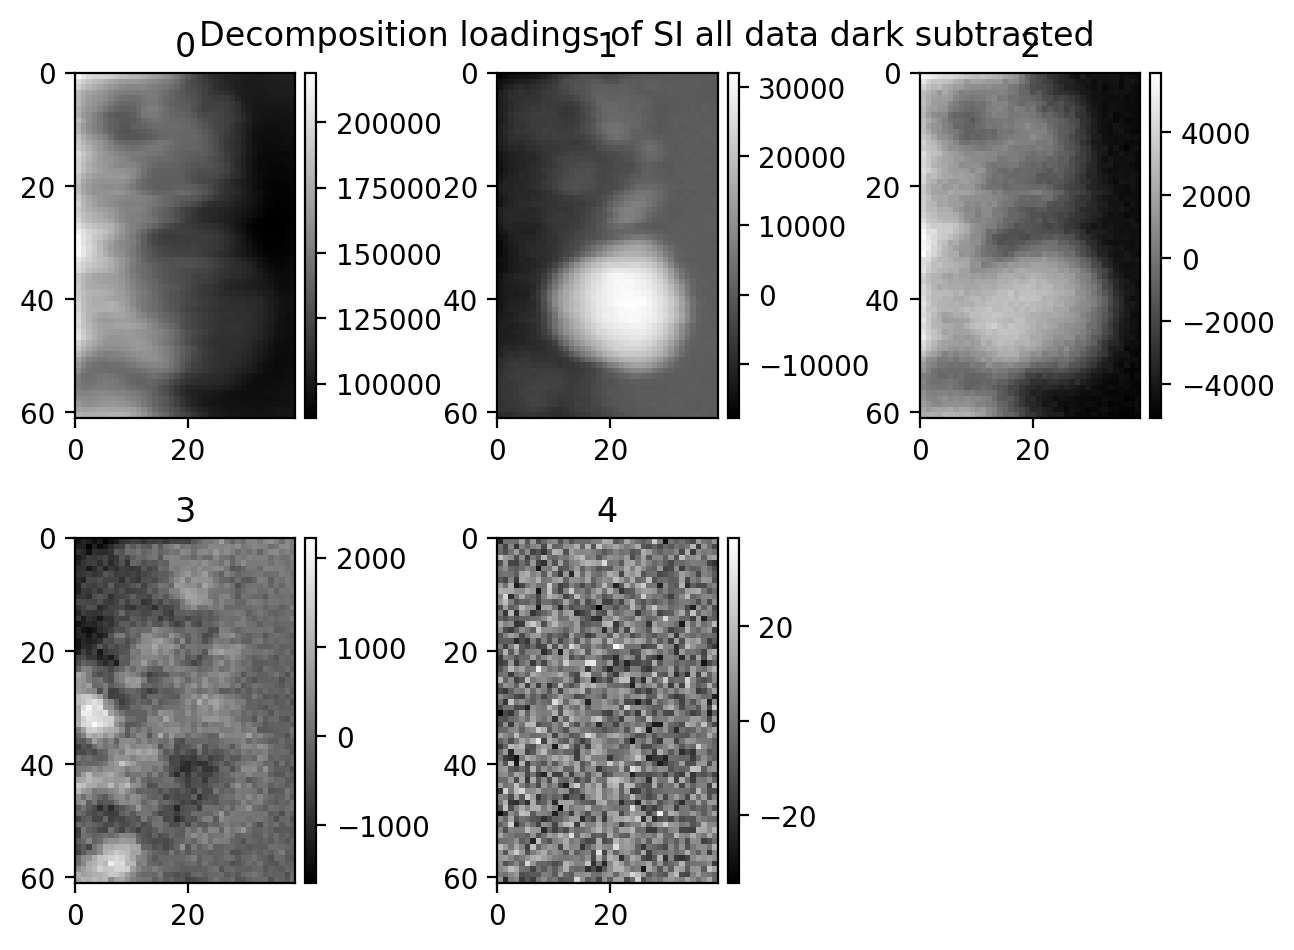

In [39]:
# s_svd = s_try.deepcopy()
# s_svd.decomposition(normalize_poissonian_noise = False, algorithm='RPCA_GoDec', lambda1=3, output_dimension=5, tol=1e-2, power=0, maxiter=3000)
# s_svd.plot_decomposition_results()
s_svd.plot_decomposition_loadings()

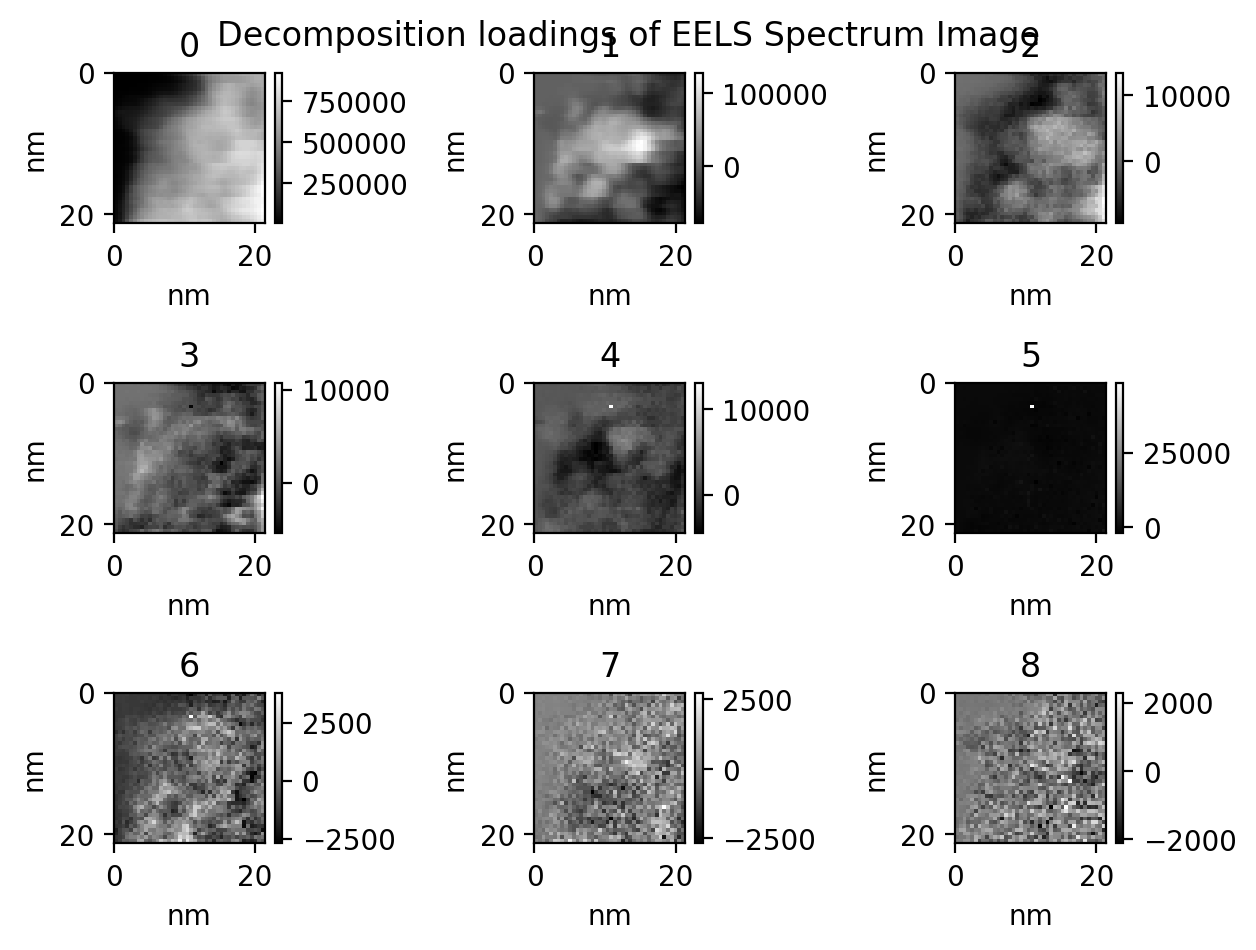

In [16]:
# s_svd = s_try.deepcopy()
# s_svd.decomposition(normalize_poissonian_noise = False, algorithm='RPCA_GoDec', lambda1=0.3, output_dimension=9, tol=1e-2, power=0, maxiter=5000)
# s_svd.plot_decomposition_results()
s_svd.plot_decomposition_loadings()

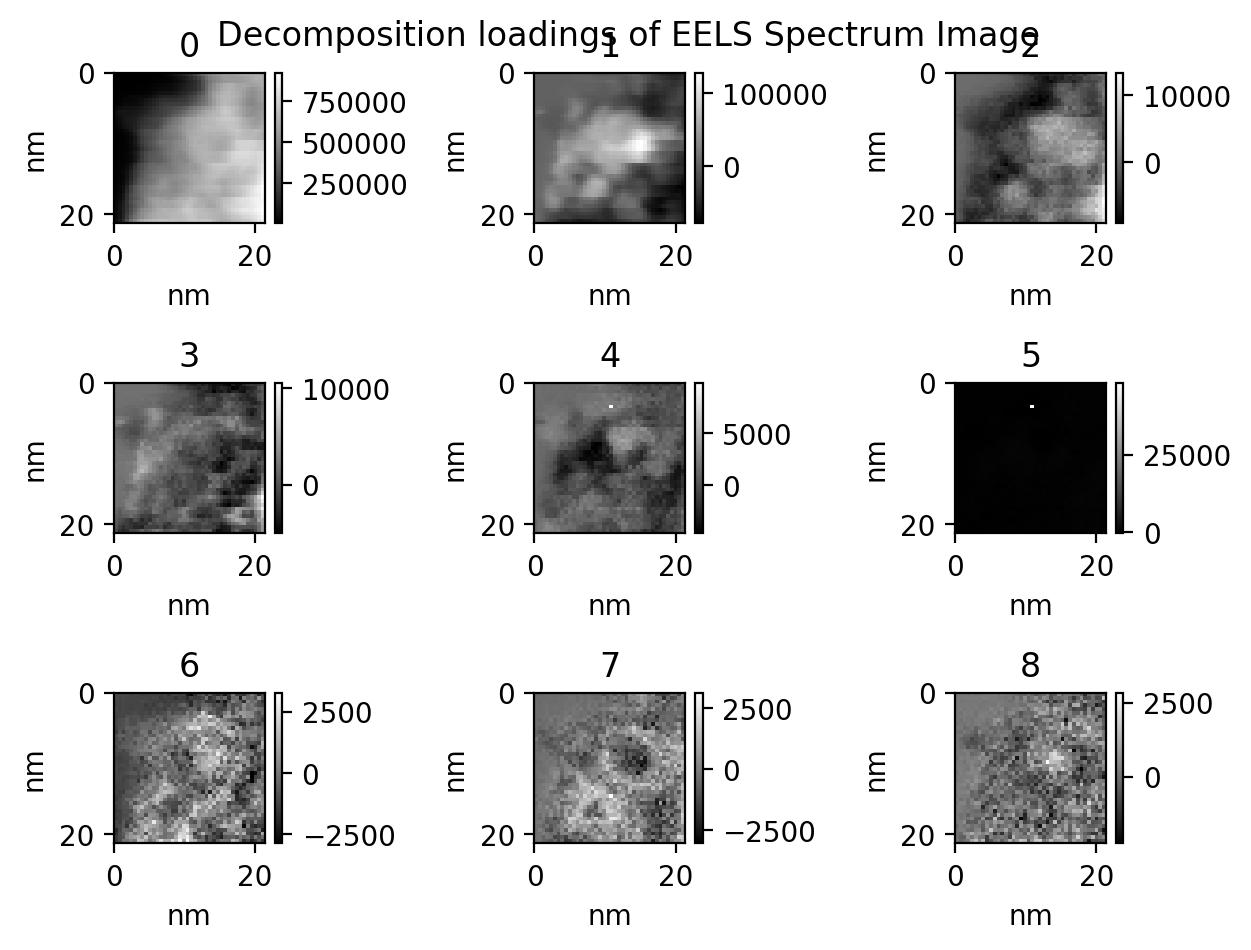

In [11]:
# s_svd = s_try.deepcopy()
# s_svd.decomposition(normalize_poissonian_noise = False, algorithm='RPCA_GoDec', lambda1=2, output_dimension=9, tol=1e-2, power=0, maxiter=5000)
# s_svd.plot_decomposition_results()
s_svd.plot_decomposition_loadings()

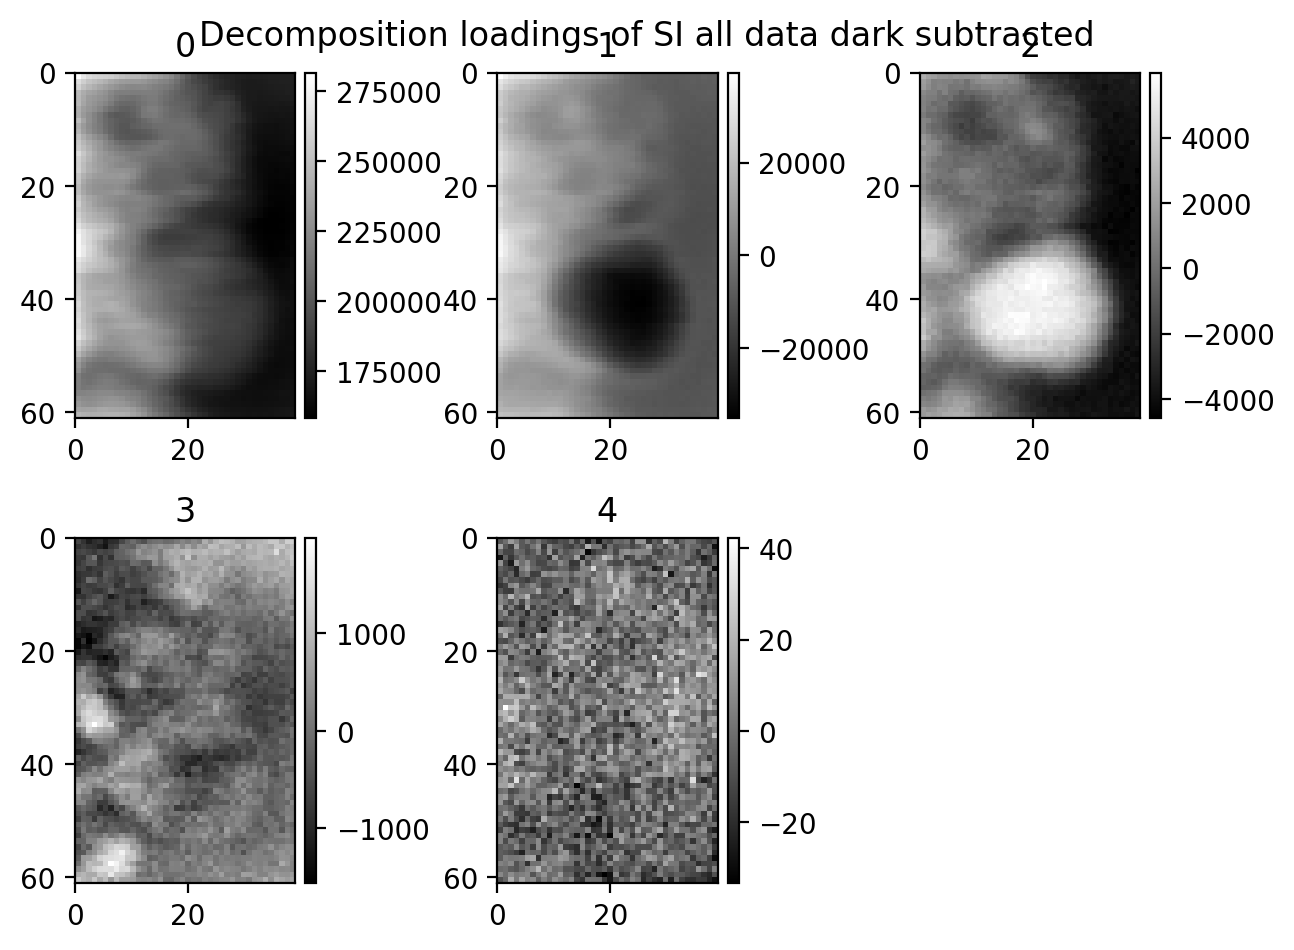

In [25]:
# s_svd = s_try.deepcopy()
# s_svd.decomposition(normalize_poissonian_noise = False, algorithm='RPCA_GoDec', lambda1=2, output_dimension=3, tol=1e-2, power=0, maxiter=5000)
# s_svd.plot_decomposition_results()
s_svd.plot_decomposition_loadings()

In [23]:
spectrum1 = s_svd.get_decomposition_model(components=[0])
# spectrum2 = s_svd.get_decomposition_model(components=[1])
# spectrum = spectrum1+spectrum2
spectrum1.remove_background()
# spectrum1.smooth_tv()

In [98]:
s_godec.blind_source_separation(comp_list=[0,2])
# new = s_svd.deepcopy()
# new.cluster_analysis(cluster_source="decomposition", number_of_components=3, preprocessing=None)
# new.plot_cluster_labels(axes_decor="off")
s_godec.plot_bss_results()

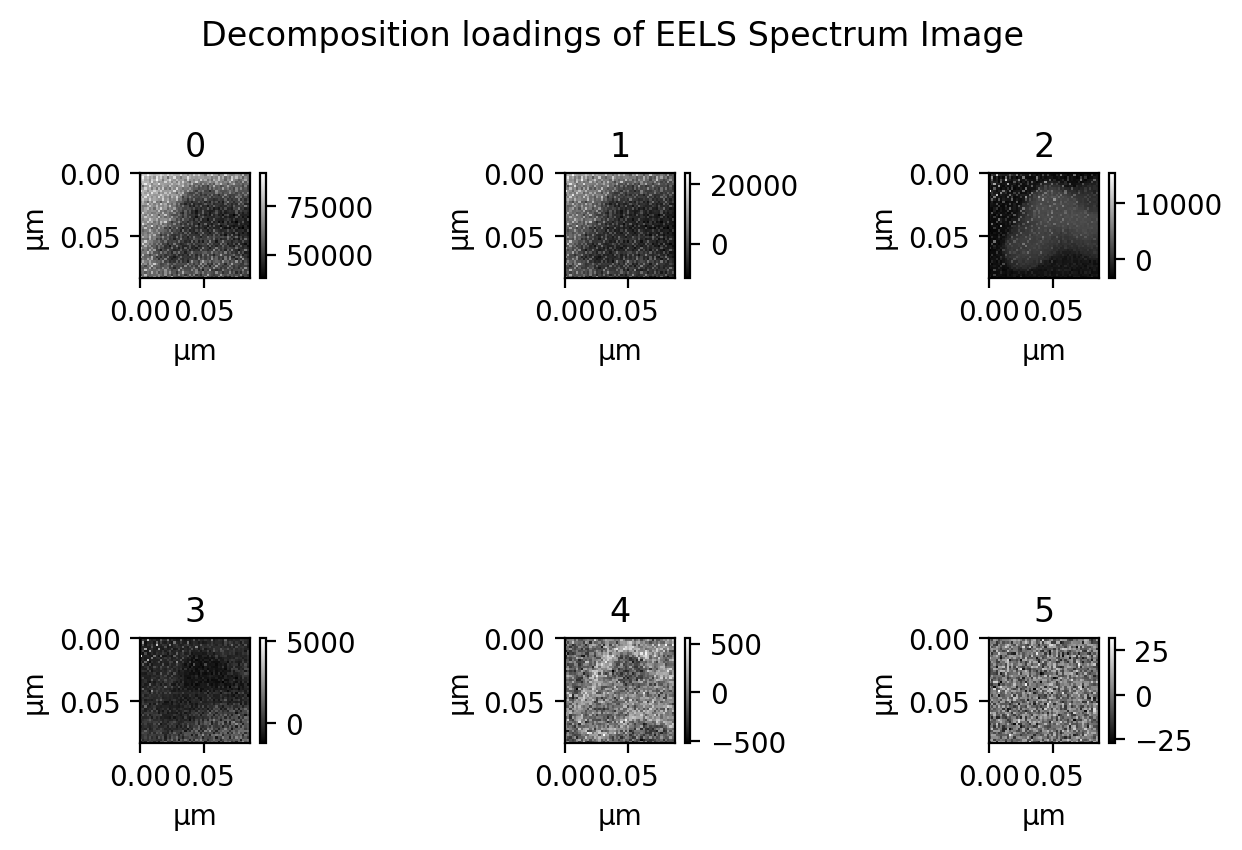

In [74]:
s_svd = s_try.deepcopy()
s_svd.decomposition(normalize_poissonian_noise = False, algorithm='RPCA_GoDec', lambda1=3, output_dimension=6, tol=1e-3, power=0, maxiter=5000)
# s_svd.plot_decomposition_results()
s_svd.plot_decomposition_loadings()
# s_svd.plot_decomposition_factors()
# s_svd.plot()

In [91]:
# s_svd = s_try.deepcopy()
# s_svd.decomposition(normalize_poissonian_noise = False, algorithm='RPCA_GoDec', lambda1=3, output_dimension=6, tol=1e-5, power=0, maxiter=3000)
s_svd.plot_decomposition_results()
# s_svd.plot_decomposition_loadings()

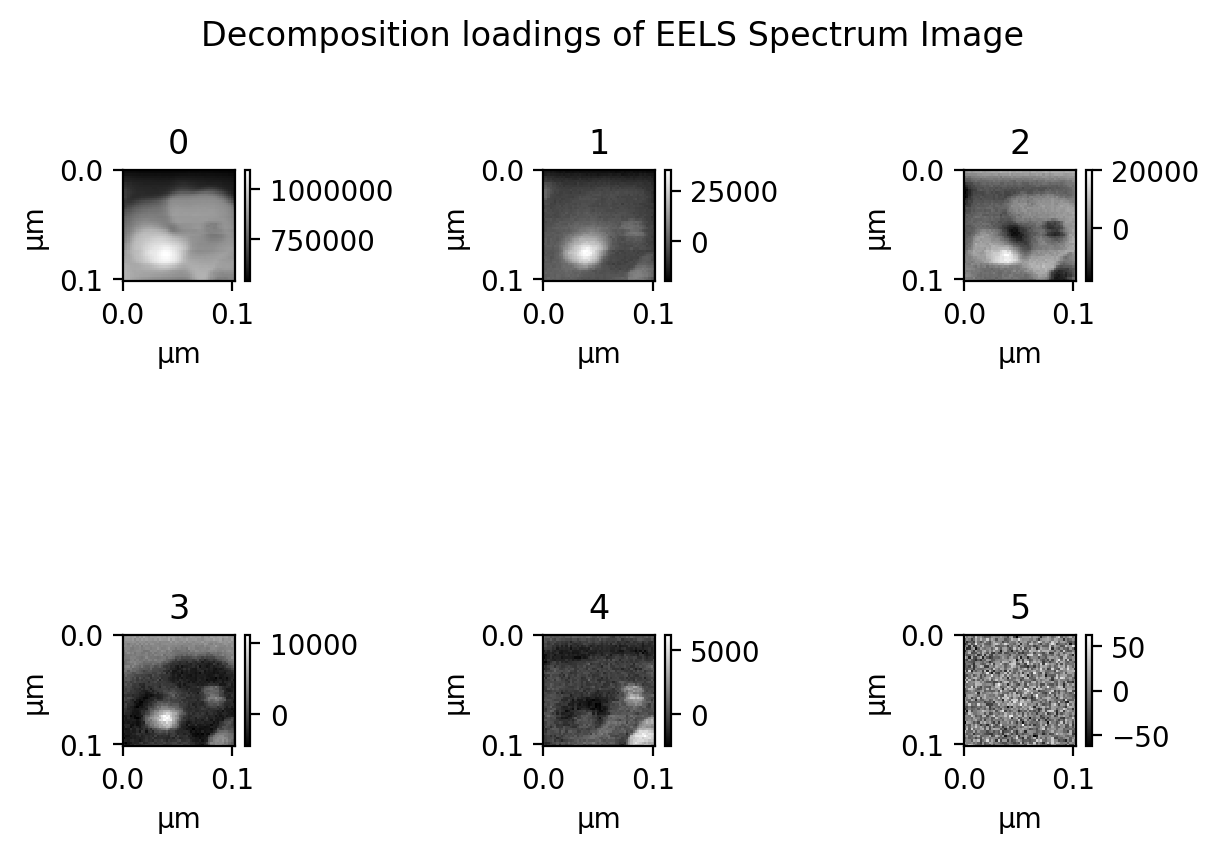

In [84]:
s_svd = s_try.deepcopy()
s_svd.decomposition(normalize_poissonian_noise = False, algorithm='RPCA_GoDec', output_dimension=6, tol=1e-3, power=0, maxiter=6000)
# s_svd.plot_decomposition_results()
s_svd.plot_decomposition_loadings()

In [30]:
# print(np.array(s_norm).shape)
model = NMF(n_components=5, init='random', random_state=0)
model.fit(s_norm_flat)

print(model.components_)
plt.plot(model.components_[3])

[[  0.         101.09283627  99.00687672 ...   1.02838266   1.35488856
    1.27207246]
 [  0.42518473   3.82516688   2.79824031 ...   5.01197338   5.19731361
    5.26594283]
 [376.52153858  22.26237874  24.34876238 ...   7.81480364   6.6753257
    6.65888882]
 [  0.          31.27408729  37.9495401  ...   7.61789814   6.61992297
    6.82154658]
 [  0.          35.71656424  29.7659305  ...   6.49102449   7.39177271
    6.30656991]]
